In [1]:
%pylab inline
import sys 
sys.path.insert(0, '..')
from n5k.calculator_base import N5KCalculatorBase
import bessel_tools

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading the results from the CCL calculator
clgg = np.load('../tests/test_clgg.npz')
clgs = np.load('../tests/test_clgs.npz')
clss = np.load('../tests/test_clss.npz')

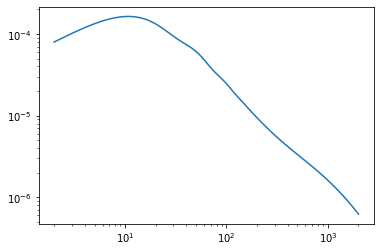

In [3]:
# And plot some results...
loglog(clgg['ls'], clgg['cls'][0])

In [67]:
from scipy.special import spherical_jn
from bessel_tools import bessel_zeros
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import simps

In [5]:
# My implementation of clgg for instance
calc = N5KCalculatorBase('tests/config.yml')
pk = calc.get_pk()
kernels = calc.get_tracer_kernels()
background = calc.get_background()
ells = calc.get_ells()

In [6]:
list(kernels.keys())

['z_cl', 'chi_cl', 'kernels_cl', 'z_sh', 'chi_sh', 'kernels_sh']

In [86]:
chi_kernel = kernels['chi_sh']
k = pk['k']
kmax = k[-1]
res_factor = 10
kmax = kmax / res_factor
# Nmax at l=0, this is conservative
nmax = int(chi_kernel[-1] * kmax / pi) 
# Retrieve once and for all the qln we need
qln = bessel_zeros(nmax, ells)

In [87]:
qln.shape

(103, 22140)

In [88]:
rln = qln / kmax

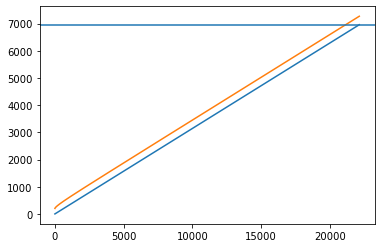

In [89]:
plot(rln[0])
plot(rln[-1])
axhline(chi_kernel[-1])

In [90]:
# Precompute transformation matrix

In [91]:
pref_factor = np.sqrt(2*pi) /( kmax**3 * np.stack([spherical_jn(int(ells[i]+1), qln[i]) 
          for i in range(len(ells)) ])**2)
# Compute Bessel term
bessel = np.stack([spherical_jn(int(ells[i]), np.outer(rln[i], k))
                  for i in range(len(ells))])

In [92]:
# Compute Bessel term
bessel = np.stack([spherical_jn(int(ells[i]), np.outer(rln[i], k))
                  for i in range(len(ells))])

In [93]:
# And here we have our transform matrix
T = np.expand_dims(pref_factor, -1) * bessel

In [94]:
T.shape

(103, 22140, 200)

In [ ]:
# The code that needs to be updated at new iterations starts here

In [95]:
z2chi = interp1d(background['z'], background['chi'])
pk_interp = interp2d(pk['k'], z2chi(pk['z']), pk['pk_nl'])
kernels_interp = [interp1d(kernels['chi_sh'], kernels['kernels_cl'][i]/kernels['chi_sh']**2, 
                      fill_value=0., bounds_error=False ) for i in range(len(kernels['kernels_cl']))]

In [96]:
integrand = np.stack([
    np.expand_dims(kernels_interp[0](rln[i]),-1) * np.sqrt(pk_interp(k, rln[i])) for i in
    range(len(ells))])

In [97]:
integrand.shape

(103, 22140, 200)

In [109]:
results =  simps((T * integrand).sum(axis=1)**2*k**2, k)

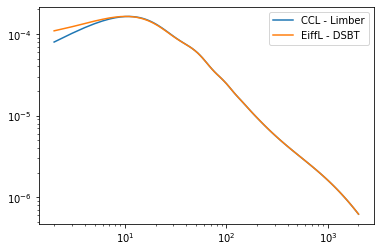

In [101]:
loglog(clgg['ls'], clgg['cls'][0], label='CCL - Limber')
loglog(ells, results*1.376695**2, label='EiffL - DSBT')
legend()

Text(0.5, 1.0, 'Absolute Relative difference to CCL-Limber')

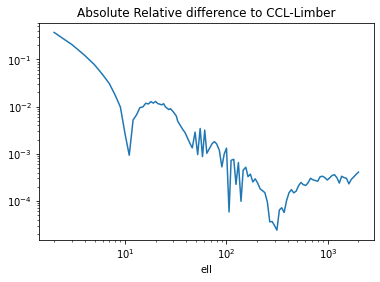

In [110]:
loglog(ells, abs(results*1.376695**2-clgg['cls'][0])/clgg['cls'][0])
xlabel('ell')
title('Absolute Relative difference to CCL-Limber')

(6.212743850263983e-07, 0.000264058504344136)

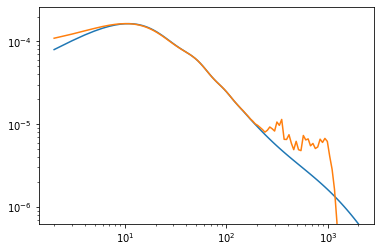

In [85]:
loglog(clgg['ls'], clgg['cls'][0])
loglog(ells, results*1.376695**2)
ylim( clgg['cls'][0].min(),  clgg['cls'][0].max()+1e-4)